# Double Variable Polynomial Regression

## Install and Import Dependencies

In [2]:
%pip install numpy pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load Data

In [4]:
df = pd.read_csv('../DoubleVariablePolynomialRegression.ipynb/data/Fish.csv')

In [5]:
df.head()

,Height,Width,Weight
0,11.5200,4.0200,242.0
1,12.4800,4.3056,290.0
2,12.3778,4.6961,340.0
3,12.7300,4.4555,363.0
4,12.4440,5.1340,430.0


## Note: No NAN Values

In [6]:
df.isna().sum()

Height    0
Width     0
Weight    0
dtype: int64

## Normalize the Features

In [7]:
df['Height'] = (df['Height']-np.mean(df['Height']))/np.std(df['Height'])
df['Width'] = (df['Width']-np.mean(df['Width']))/np.std(df['Width'])
df.head()

,Height,Width,Weight
0,0.596579,-0.236529,242.0
1,0.821261,-0.066579,290.0
2,0.797341,0.165793,340.0
3,0.879771,0.022621,363.0
4,0.812835,0.426371,430.0


## Generate Random Test and Train Splits

In [8]:
seed = 420
train_fraction = 0.8
train = df.sample(frac=train_fraction, random_state=seed)
test = df.drop(train.index)

## Polynomial Regression Model

In [19]:
class PolynomialRegressionModel:
    def __init__(self, i, j, q, lmbda):
        """
        Polynomial Regression Model for some particular degree.
        """
        self.train_errors = {}
        self.test_errors = {}
        self.q = q
        self.lmbda = lmbda
        self.i = i
        self.j = j
        self.weights = np.random.rand(i+1, j+1)

    def calculate_loss(self, X_i, t_i):
        # print('inside self.calculate_loss()')
        assert type(X_i[0]) == np.float64 and type(t_i) == np.float64 and type(X_i[1]) == np.float64, "Types are not matching. Check!"
        result = np.zeros_like(self.weights)
        a = X_i[0]
        b = X_i[1]
        t = t_i
        prediction = self.predict([(a, b)])
        # print('predicted:')
        # print(prediction)
        # print('expected')
        # print(target)

        # tmp = np.sum(self.weights * np.power(a, np.arange(self.i + 1))[:, np.newaxis] * np.power(b, np.arange(self.j + 1)), axis=(0, 1))

        exponents_a = np.arange(self.i + 1)[:, np.newaxis]
        exponents_b = np.arange(self.j + 1)
        result = -1*np.outer(np.power(a, exponents_a), np.power(b, exponents_b)) * (t - prediction)

        # print('loss: ')
        # print(result)
        return result

    def fit(self, X_train, y_train, X_test, y_test, lr=0.01, epochs=500, batch_size=20):
        """
        Fit the polynomial regression model using Batch Gradient Descent.

        Parameters:
        X_train: Input Feature variables.
        y_train: Target Variable
        X_test: Input Feature variables for test data
        y_test: Target Variables for test data
        lr: Learning Rate for Gradient Descent
        epochs: No of Epochs to train

        Returns:
        NA
        """
        print('Starting Training.....')
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        # print(X_train.head())
        for epoch in range(epochs):
            count = 0
            loss = np.zeros_like(self.weights)
            # print(X_train.shape[0])
            
            for i in range(X_train.shape[0]):
                # print('sample')
                # print(X_train[i][0])
                # print(X_train[i][1])
                # print(y_train[i])
                if epoch == 0 or (i % batch_size == 0):
                    self.train_errors[epoch*epochs + i] = self.calculate_error(X_train, y_train)
                    self.test_errors[epoch*epochs + i] = self.calculate_error(X_test, y_test)

                X_i = (X_train[i][0],X_train[i][1])
                t_i =  y_train[i]

                if count%batch_size == 0:
                    loss /= batch_size
                    # print('loss: ')
                    # print(loss)
                    self.weights += (self.lmbda*self.q//2)*(np.abs(self.weights)**(self.q-1))
                    self.weights -= lr*loss
                    loss = np.zeros_like(self.weights)
                else:
                    loss += self.calculate_loss(X_i, t_i)
                    self.train_errors[count] = self.calculate_error(X_train, y_train);
                    self.test_errors[count] = self.calculate_error(X_test, y_test);
            
                count+=1
            # if epoch%(epochs/10) == 0:
            #     print(f"epoch: {epoch}")
            #     print(f"Train Loss: {self.train_errors}")
            #     print(f"Test Loss: {self.test_errors}")

        return

    def calculate_error(self, X_test, y_test):
        """
        Find the error of the model on some data.

        Parameters:
        X_test: The sample Input Feature.
        y_test: The sample Target Feature.

        Returns:
        A float value that is the MSE b/w the predicted outputs and the target outputs.
        """
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        predictions = self.predict(X_test)
        mse = np.mean(
            (predictions-y_test)**2
        )
        return mse

    def predict(self, X_test):
        """
        Make Predictions using the trained model.

        Parameters:
        X_test: The sample Input Features.

        Returns:
        A numpy Array with the predicted target variable value for each of the samples having
        same dimensions as X_test.
        """
        result = [] 
        for sample in X_test:
            assert type(sample[0]) == np.float64 and type(sample[1]) == np.float64, "Variable doesn't have the required type!"
            a = sample[0]
            b = sample[1]
            tmp = np.sum(self.weights * np.power(a, np.arange(self.i + 1))[:, np.newaxis] * np.power(b, np.arange(self.j + 1)), axis=(0, 1))           
            result.append(tmp)
        return np.array(result)

## Plots

In [21]:
degrees = [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9]  # List of polynomial degrees to test
all_train_errors = []
all_test_errors = []
min_train_errors = []
min_test_errors = []

for deg in degrees:
    model = PolynomialRegressionModel(i=2, j=2, q=deg, lmbda=0)
    model.fit(train.drop(['Weight'], axis=1), train['Weight'], test.drop(['Weight'], axis=1), test['Weight'], lr=0.001, epochs=100)
    
    # Store training and testing errors for this degree
    all_train_errors.append(model.train_errors)
    all_test_errors.append(model.test_errors)
    
    # Get the minimum training and testing errors
    min_train_error = min([entry for entry in model.train_errors.values()])
    min_test_error = min([entry for entry in model.test_errors.values()])
    
    min_train_errors.append(min_train_error)
    min_test_errors.append(min_test_error)
    
    print(f"Degree {deg}:")
    print(f"Minimum Train Error: {min_train_error}")
    print(f"Minimum Test Error: {min_test_error}")
    print("-------------------")

# Display the best degree
best_degree = degrees[np.argmin(min_train_errors)]
print(f"Best degree of polynomial: {best_degree}")


Starting Training.....
Degree 0:
Minimum Train Error: 53072.09397392719
Minimum Test Error: 89755.13359871
-------------------
Starting Training.....
Degree 1:
Minimum Train Error: 53085.13139793781
Minimum Test Error: 89732.03213397988
-------------------
Starting Training.....
Degree 2:
Minimum Train Error: 53096.601557574475
Minimum Test Error: 89696.82310603288
-------------------
Starting Training.....
Degree 3:
Minimum Train Error: 53089.08648459167
Minimum Test Error: 89793.41272926814
-------------------
Starting Training.....
Degree 4:
Minimum Train Error: 53216.92830454346
Minimum Test Error: 89848.76336031037
-------------------
Starting Training.....
Degree 5:
Minimum Train Error: 53089.060017504016
Minimum Test Error: 89737.66486622303
-------------------
Starting Training.....
Degree 6:
Minimum Train Error: 52966.764284697376
Minimum Test Error: 89633.79226026894
-------------------
Starting Training.....
Degree 7:
Minimum Train Error: 53056.65059954847
Minimum Test Error

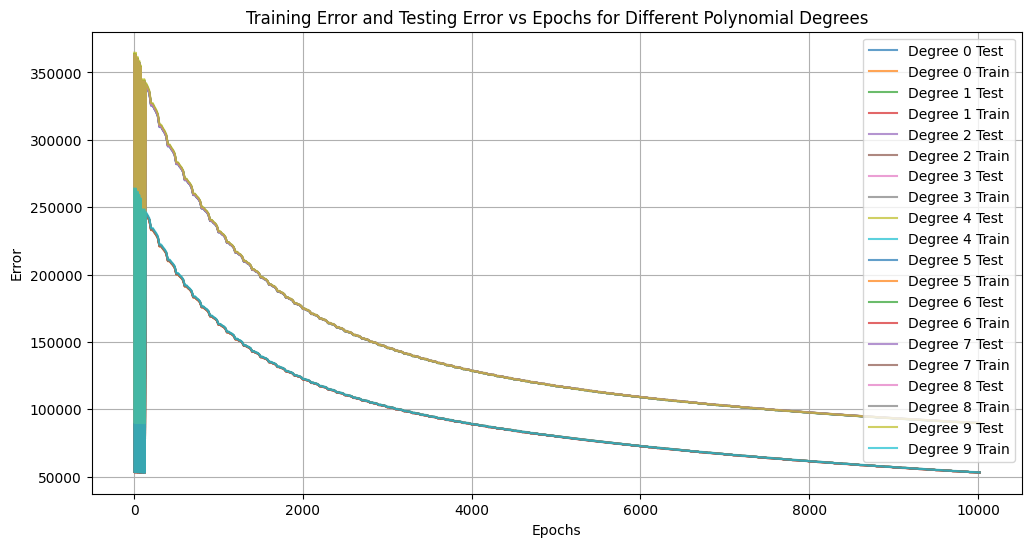

In [22]:
# Plot training and testing errors vs. epochs for all degrees
plt.figure(figsize=(12, 6))
for i, deg in enumerate(degrees):
    epochs = list(all_test_errors[i].keys())
    test_errors = list(all_test_errors[i].values())
    train_errors = list(all_train_errors[i].values())
    
    plt.plot(epochs, test_errors, label=f'Degree {deg} Test', alpha=0.7)
    plt.plot(epochs, train_errors, label=f'Degree {deg} Train', alpha=0.7)

plt.title('Training Error and Testing Error vs Epochs for Different Polynomial Degrees')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
a_values = np.linspace(min(train.to_numpy()[:, 0]), max(train.to_numpy()[:, 0]), 100)
b_values = np.linspace(min(test.to_numpy()[:, 1]), max(train.to_numpy()[:, 1]), 100)
a_mesh, b_mesh = np.meshgrid(a_values, b_values)

In [14]:
prediction_points = np.c_[a_mesh.ravel(), b_mesh.ravel()]
predictions = model.predict(prediction_points)

In [15]:
predictions_surface = predictions.reshape(a_mesh.shape)


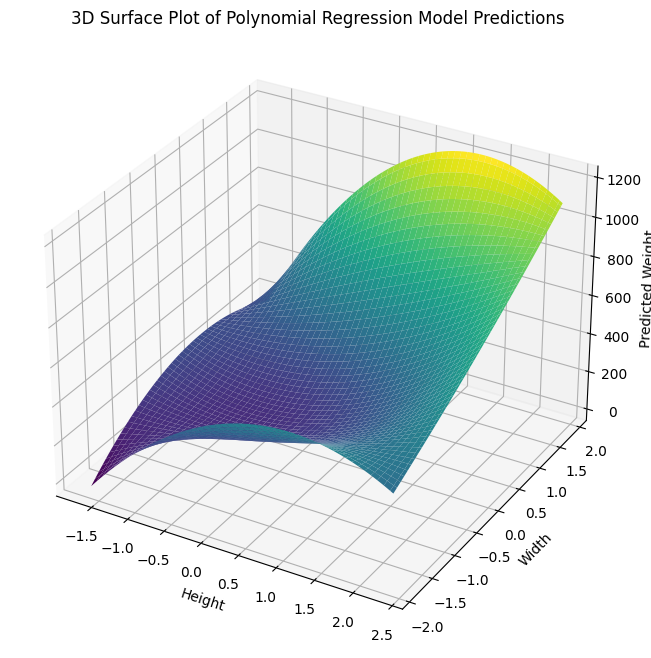

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(a_mesh, b_mesh, predictions_surface, cmap='viridis')

# ax.scatter((train+test .to_numpy()[:, 0], train.to_numpy()[:, 1], train['Weight'].to_numpy(), color='blue', marker='o')

ax.set_xlabel('Height')
ax.set_ylabel('Width')
ax.set_zlabel('Predicted Weight')

plt.title('3D Surface Plot of Polynomial Regression Model Predictions')
plt.show()

## Grid Search

## Without Regularization

In [17]:
import json

In [ ]:
errors = []
for lr in [0.001]:
    for q in [0.5, 1, 2, 4]:
        for batch_size in [20, 1]:
            for lmbda in [0.0, 0.3, 0.5, 0.8, 1.0]:
                print(f"doing: {2}, {2}, {lr}, {q}, {batch_size} for 100 epochs")
                model = PolynomialRegressionModel(i=2, j=2, q=q, lmbda=lmbda)
                model.fit(train.drop(['Weight'], axis=1), train['Weight'], test.drop(['Weight'], axis=1), test['Weight'], lr=lr, epochs=100, batch_size=batch_size)
                errors.append({
                    "i": 2,
                    "j": 2,
                    "lr": lr,
                    "q": q, 
                    "lmbda": lmbda,
                    "batch_size": batch_size,
                    "test_errors": model.test_errors,
                    "train_errors": model.train_errors
                })
                # print(errors)

with open('double_withreg.json', 'w') as fp:
    json.dump(errors, fp)


## With Regularization

In [ ]:
errors = []
# Note this should be chosen from analysis of previous grid search without regularization
best_fit_i = 1
best_fit_j = 1
for i in [best_fit_i]:  
    for j in  [best_fit_j]:
        for lr in [0.1, 0.001, 0.0001]:
            for q in [0.5, 1, 2, 4]:
                for batch_size in [20, 1]:
                    for lmbda in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
                        print(f"doing: {i}, {j}, {lr}, {q}, {batch_size} for 100 epochs")
                        model = PolynomialRegressionModel(i=i, j=j, q=q, lmbda=lmbda)
                        model.fit(train.drop(['Weight'], axis=1), train['Weight'], test.drop(['Weight'], axis=1), test['Weight'], lr=lr, epochs=100, batch_size=batch_size)
                        errors.append({
                            "i": i,
                            "j": j,
                            "lr": lr,
                            "q": q, 
                            "lmbda": lmbda,
                            "batch_size": batch_size,
                            "test_errors: ": model.test_errors,
                            "train_errors: ": model.train_errors
                        })
                        print(errors)
json_obj = json.dumps(errors)
with open('double_withreg.json', 'w') as fp:
    json.dump(json_obj, fp)